# Workflow example to generate timelapses

This example illustrates how to use an `EOWorkflow` to create time-lapses

### Create cloudless timelapse

Imports from `sentinelhub` and `eolearn` to set up workflow that creates a timelapse

In [1]:
from sentinelhub import BBox, CRS, MimeType, CustomUrlParam
import numpy as np
import datetime

In [2]:
from eolearn.mask import AddCloudMaskTask, get_s2_pixel_cloud_detector
from eolearn.core import EOPatch
from eolearn.core.eodata import FeatureType
from eolearn.core.eoworkflow import LinearWorkflow, Dependency
from eolearn.features import SimpleFilterTask
from eolearn.io import S2L1CWCSInput

In [4]:
from eolearn.core import SaveToDisk, LoadFromDisk
from eolearn.io import S2L1CWCSInput, AddSen2CorClassificationFeature, DEMWCSInput, S2L2AWCSInput, L8L1CWCSInput

Set up BBox of ROI and time interval

In [115]:
roi_bbox = BBox(bbox=[113.4705, 39.9697, 113.4951, 39.9871], crs=CRS.WGS84)
time_interval = ('2017-02-01', '2017-08-01')

 Tasks of the workflow:
 * download S2 images (all 13 bands)
 * filter out images with cloud coverage larger than a given threshold (e.g. 0.05)

In [124]:
layer='BANDS-S2-L1C'

wcs_task = S2L1CWCSInput(layer=layer, 
                         resx='5m',
                         resy='5m',
                         maxcc=.05, time_difference=datetime.timedelta(hours=1))

save = SaveToDisk('timelapse_example', overwrite_permission=2, compress_level=1)

Build and execute timelapse as chain of transforms

In [125]:
timelapse =LinearWorkflow(wcs_task, save)

result = timelapse.execute({
    wcs_task: {'bbox': roi_bbox, 'time_interval': time_interval},
                           save: {'eopatch_folder': 'eopatch'}})

Get result as an eopatch

In [126]:
eopatch = result[save]
eopatch

EOPatch(
  data: {
    BANDS-S2-L1C: numpy.ndarray(shape=(4, 387, 419, 13), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(4, 387, 419, 1), dtype=bool)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.05
    service_type: 'wcs'
    size_x: '5m'
    size_y: '5m'
    time_difference: datetime.timedelta(0, 3600)
    time_interval: ('2017-02-01', '2017-08-01')
  }
  bbox: BBox(((113.4705, 39.9697), (113.4951, 39.9871)), crs=EPSG:4326)
  timestamp: [datetime.datetime(2017, 4, 1, 3, 18, 46), ..., datetime.datetime(2017, 7, 30, 3, 21, 38)], length=4
)

#### Help function to create GIFs

In [128]:
import imageio, os

def make_gif(eopatch, project_dir, filename, fps):
    """
    Generates a GIF animation from an EOPatch.
    """
    with imageio.get_writer(os.path.join(project_dir, filename), mode='I', fps=fps) as writer:
            for image in eopatch:
                writer.append_data(np.array(image[..., [3, 2, 1]], dtype=np.uint8))

Write EOPatch to GIF

In [129]:
make_gif(eopatch=eopatch.data['BANDS-S2-L1C']*2.5*255, project_dir='.', filename='eopatch_timelapse1.gif', fps=1)

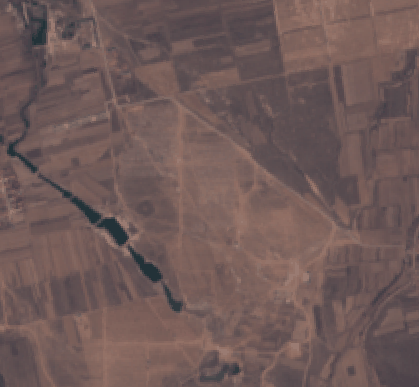

In [130]:
from IPython.display import Image

Image(filename="eopatch_timelapse1.gif")